## Notebook for precip's northern hemisphere summer 95th percentile maps in GDPCIR paper

#### last updated : 2022/11/15, by Emile Tenezakis (e.tenezakis@gmail.com). 
#### scaling : with a remote dask cluster as a backend to the xarray datasets. With the cluster scaling parameters as is, notebook should take around 10 minutes, including normal cluster spin up time. 
#### output : notebook saves the figure to user specific `figure_3_output_file_path` defined below.
#### library dependencies : This ran on rhodium's onyx environment, with the open source rhodium `rhg_compute_tools` and open source `dodola` packages pip-installed in editable mode (if using onyx, install both without their dependencies with the `--no-deps` flag).  
#### data dependencies : publicly available GDPCIR datasets stored on google cloud, and a yaml file containing the URLs to these datasets. This yaml file is available in the GDPCIR github repository, specify your local path to it below with `fps_yaml_path`. 

In [1]:
import dask
import xarray as xr
import numpy as np
import pandas as pd
import yaml
from rhg_compute_tools import kubernetes as rhgk
from dodola.services import xesmf_regrid
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

/tmp/ipykernel_25639/2586608519.py:6: DeprecationWarning: rhg_compute_tools and the associated command-line application rctools are
deprecated on catalyst clusters. use catalyst_compute_tools instead.
See https://gitlab.com/crs-catalyst/infrastructure/catalyst_compute_tools/-/issues/1
  from rhg_compute_tools import kubernetes as rhgk


In [2]:
# global variables
figure_3_output_file_path = '/home/jovyan/tests/precip_summer_q95_with_capped_biascorrected_and_diffs.png' # put that wherever you want
with open('/home/jovyan/repositories/downscaleCMIP6/notebooks/downscaling_pipeline/post_processing_and_delivery/data_paths.yaml', 'r') as f:
    fps = yaml.load(f, yaml.Loader)
model = 'NorESM2-LM'
fut_scenario = 'ssp370'
var = 'pr'
months = [6,7,8]
q=0.95
TITLE = '95th Percentile JJA Precipitation. SSP3-7.0. NorESM2-LM'

In [3]:
# each 50 workers get 1/2 a 48GiB Node. 
# necessary to use half a node b/c of reanalysis. 
client, cluster = rhgk.get_big_cluster()
cluster.scale(75)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/jhub.6136771002d74fd28f7c74632fe5a80f/status,


In [5]:
def cyclic_lon(da):
    """
    [0, 360] - > [-180, 180]
    """
    return da.assign_coords({'lon':xr.where(da.lon>180, da.lon-360, da.lon)}).sortby('lon')    

In [6]:
def read_data(model=model, scenario=fut_scenario, step_label='downscaled_delivered', pix=None, ref=False, chunks='auto', fps=fps):
    if ref:
        if step_label == 'downscaled_delivered':
            # "QPLAD fine reference zarr"
            da_pr = xr.open_zarr('gs://support-c23ff1a3/qplad-fine-reference/pr/v20220201000555.zarr', chunks=chunks)['pr']
        elif step_label == 'biascorrected':
            # "QDM reference zarr"
            da_pr = xr.open_zarr('gs://support-c23ff1a3/qdm-reference/pr/v20220201000555.zarr', chunks=chunks)['pr']
        else:
            raise ValueError
    else:
        da_pr = xr.open_zarr(fps[f'{model}-pr'][scenario][step_label], chunks=chunks)['pr']
    if pix is not None:
        da_pr = da_pr.isel(lat=pix['lat'], lon=pix['lon'], drop=True)
    return da_pr

In [7]:
def cap_precip(ref, hist, fut):
    # compute ref max over training period
    ref_max_pr = ref.sel(time=slice('1994-12-16', '2015-01-15')).max('time').compute()
    # comput hist max over training period
    hist_max_pr = hist.sel(time=slice('1994-12-16', '2015-01-15')).max('time').compute()
    # compute fut max over 21 year period the given date falls in
    max_pr_per_year = (
        xr.concat([hist, fut], dim='time')
        .groupby('time.year')
        .max(dim='time')
        .rolling(year=21, center=True, min_periods=21)
        .max()
        .compute()
    )
    
    # compute the factor making sure not to leave nans around
    factor = (
        (max_pr_per_year.dropna(dim='year', how='all') / hist_max_pr)
    )
    # compute the cap with all this
    cap_values = ref_max_pr * np.maximum(1, factor)
    
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        cap_values_expanded = (
            cap_values
            .reindex(year=np.unique(fut.time.dt.year), method='nearest')
            .sel(year=fut.time.dt.year)
            .drop('year')
        )
        
        capped_fut = np.minimum(fut, cap_values_expanded)
        
        
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        cap_values_expanded_hist = (
            cap_values
            .reindex(year=np.unique(hist.time.dt.year), method='nearest')
            .sel(year=hist.time.dt.year)
            .drop('year')
        )
        
        capped_hist = np.minimum(hist, cap_values_expanded_hist)
        
    return capped_hist, capped_fut

In [8]:
def gcm_historical_q(model, step_label, hist_period=range(1995, 2014+1), months=months, quantile=q, pix=None) -> xr.DataArray():
    
    """
    function that loads GCM data at the step `step_label` (raw, bias corrected, downscaled etc) from the URLs yaml file and computes the trend in a particular seasonal quantile of tasmax for `model`, scenario `fut_scenario`, variable `var. Trend is computed between `fut_period` and `hist_period`. Season is defined with `months`. Quantile is defined with `quantile`. 
    
    You can locally, without the dask cluster, test the function with `pix`.
    """
    hist = read_data(model=model, scenario='historical', step_label=step_label, pix=pix)
    
    hist = hist.where(hist.time.dt.year.isin(hist_period), drop=True)
    hist = hist.where(hist.time.dt.month.isin(months), drop=True)
    
    if pix is not None:
        hist = hist.load()
    else:
        # move chunks to space to take temporal quantile
        hist = hist.chunk({'time': -1, 'lat': 360, 'lon': 360})

    hist_q = hist.quantile(q=quantile, dim='time')
    
    return hist_q

In [9]:
def gcm_q_trend(model, fut_scenario, step_label, fut_period=range(2080, 2100+1), hist_period=range(1995, 2014+1), months=months, quantile=q, pix=None) -> xr.DataArray():
    
    
    """
    function that loads GCM data at the step `step_label` (raw, bias corrected, downscaled etc) from the URLs yaml file and computes the trend in a particular seasonal quantile of tasmax for `model`, scenario `fut_scenario`, variable `var. Trend is computed between `fut_period` and `hist_period`. Season is defined with `months`. Quantile is defined with `quantile`. 
    
    You can locally, without the dask cluster, test the function with `pix`.
    """
    fut = read_data(model=model, scenario=fut_scenario, step_label=step_label, pix=pix, chunks=None if pix is not None else 'auto')
    hist = read_data(model=model, scenario='historical', step_label=step_label, pix=pix, chunks=None if pix is not None else 'auto')

    if pix is not None:
        fut = fut.load()
        hist = hist.load()
      
    fut = fut.where(fut.time.dt.year.isin(fut_period), drop=True)
    fut = fut.where(fut.time.dt.month.isin(months), drop=True)

    
    hist = hist.where(hist.time.dt.year.isin(hist_period), drop=True)
    hist = hist.where(hist.time.dt.month.isin(months), drop=True)
    
    if pix is None:
        # move chunks to space to take temporal quantile
        fut = fut.chunk({'time': -1, 'lat': 360, 'lon': 360})
        hist = hist.chunk({'time': -1, 'lat': 360, 'lon': 360})
    else:
        fut = fut.load()
        hist = hist.load()
    
    fut_q = fut.quantile(q=quantile, dim='time')
    hist_q = hist.quantile(q=quantile, dim='time')
    trend = fut_q - hist_q
    
    return trend

In [10]:
def gcm_q_trend_biascorrected_pix(pix, model, fut_scenario, fut_period=range(2080, 2100+1), hist_period=range(1995, 2014+1), months=months, quantile=q) -> xr.DataArray():
    
    """
    function that loads GCM data at the step `step_label` (raw, bias corrected, downscaled etc) from the URLs yaml file and computes the trend in a particular seasonal quantile of tasmax for `model`, scenario `fut_scenario`, variable `var. Trend is computed between `fut_period` and `hist_period`. Season is defined with `months`. Quantile is defined with `quantile`. 
    
    You can locally, without the dask cluster, test the function with `pix`.
    """
    fut = read_data(model=model, scenario=fut_scenario, step_label='biascorrected', pix=pix, chunks=None)
    hist = read_data(model=model, scenario='historical', step_label='biascorrected', pix=pix, chunks=None)

    fut = fut.load()
    hist = hist.load()
  
    ref = read_data(step_label='biascorrected', ref=True,pix=pix, chunks=None)
    ref = ref.load()
    hist, fut = cap_precip(ref, hist, fut)
        
    fut = fut.where(fut.time.dt.year.isin(fut_period), drop=True)
    fut = fut.where(fut.time.dt.month.isin(months), drop=True)

    
    hist = hist.where(hist.time.dt.year.isin(hist_period), drop=True)
    hist = hist.where(hist.time.dt.month.isin(months), drop=True)
    

    fut_q = fut.quantile(q=quantile, dim='time')
    hist_q = hist.quantile(q=quantile, dim='time')
    trend = fut_q - hist_q
    
    return trend

In [11]:
def gcm_q_trend_biascorrected(**kwargs): 
    pixs = [{'lat': [x], 'lon': list(range(0, 360))} for x in range(0, 180)]
    futs = client.map(gcm_q_trend_biascorrected_pix, pixs, **kwargs)
    results = client.gather(futs)
    return xr.combine_by_coords(results).pr

In [12]:
def ref_q(period=range(1995, 2014+1),months=months,quantile=q, pix=None) -> xr.DataArray():

    """
    function that loads tasmax reanalysis data and computes the `quantile` of the time series subset defined by `period` (years) and `months` (seasonality). 
    
    You can locally, without the dask cluster, test the function with `pix`.
    """
    
    ref_da = read_data(ref=True, step_label='downscaled_delivered', pix=pix)
    
    ref_da = ref_da.where(ref_da.time.dt.year.isin(period), drop=True)
    ref_da = ref_da.where(ref_da.time.dt.month.isin(months), drop=True)
    
    if pix is not None:
        ref_da = ref_da.load()
    else:
        # move chunks to space to take temporal quantile
        ref_da = ref_da.chunk({'time':-1, 'lat':360, 'lon':360})
    ref_q = ref_da.quantile(q=quantile, dim='time')
    return ref_q

In [13]:
def regrid_to_downscaled_resolution(da, method='nearest_s2d'):
    """
    regrid a lat/lon dataarray to the downscaling resolution using dodola's `xesmf_regrid`. 
    """
    domain_ds = xr.open_zarr('gs://support-c23ff1a3/domain.0p25x0p25.zarr', chunks=None)
    da = xesmf_regrid(x=xr.Dataset({'da':da}), domain=domain_ds, method=method, astype=np.float32, add_cyclic=None, keep_attrs=True)['da']
    return da

In [14]:
# unit test gcm_q_trend_biascorrected_pix
# took a couple seconds and non significant memory footprint
# import time
# t0 = time.time()
# out_pix = gcm_q_trend_biascorrected_pix(pix={'lat':[0], 'lon':list(range(0, 360))}, model=model, fut_scenario=fut_scenario)
# t1 = time.time()

In [15]:
# returns an xarray object with an numpy array, not a chunked dask array
biascorrected_trend = gcm_q_trend_biascorrected(model=model, fut_scenario=fut_scenario)

In [16]:
biascorrected_trend_regridded = regrid_to_downscaled_resolution(biascorrected_trend)

In [17]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    downscaled_trend = gcm_q_trend(model=model, fut_scenario=fut_scenario, step_label='downscaled_delivered')

In [18]:
downscaled_trend = downscaled_trend.compute()

In [19]:
raw_cleaned_historical_q = gcm_historical_q(model=model, step_label='clean')

In [20]:
raw_cleaned_historical_q = raw_cleaned_historical_q.compute()

In [21]:
raw_cleaned_trend = gcm_q_trend(model=model, fut_scenario=fut_scenario, step_label='clean')

In [22]:
raw_cleaned_trend = raw_cleaned_trend.compute()

In [23]:
raw_cleaned_trend = cyclic_lon(raw_cleaned_trend)

In [24]:
raw_cleaned_trend_regridded = regrid_to_downscaled_resolution(raw_cleaned_trend)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [25]:
diff_downscaled_regriddedraw = (downscaled_trend - raw_cleaned_trend_regridded)

In [26]:
diff_downscaled_biascorrected = (downscaled_trend - biascorrected_trend_regridded)

In [27]:
diff_regriddedbiascorrected_regriddedraw = (biascorrected_trend_regridded - raw_cleaned_trend_regridded)

In [28]:
# test on one pixel
# test_ref_q = ref_q(pix={'lat':300, 'lon':300})

In [29]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    reference_quantile = ref_q()

In [30]:
reference_quantile = reference_quantile.compute()

In [31]:
reference_quantile = cyclic_lon(reference_quantile)

In [32]:
raw_cleaned_historical_regridded = regrid_to_downscaled_resolution(cyclic_lon(raw_cleaned_historical_q))

/srv/conda/envs/notebook/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [33]:
diff_raw_cleaned_historical_reference = raw_cleaned_historical_regridded - reference_quantile

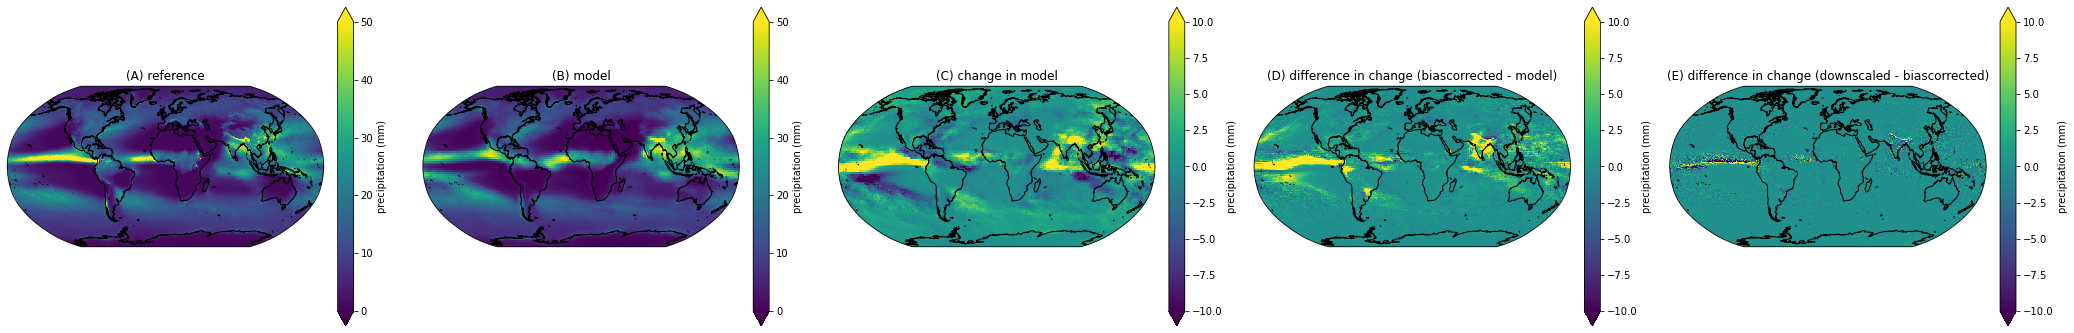

In [44]:
plot_kwargs = dict(cmap='viridis', vmin=-10, vmax=10)
diff_plot_kwargs = dict(cmap='viridis', vmin=-10, vmax=10)
abs_plot_kwargs = dict(cmap='viridis', vmin=0, vmax=50)
all_pieces = [reference_quantile, raw_cleaned_historical_regridded, raw_cleaned_trend, diff_regriddedbiascorrected_regriddedraw, diff_downscaled_biascorrected]
titles = ['(A) reference', '(B) model', '(C) change in model', '(D) difference in change (biascorrected - model)', '(E) difference in change (downscaled - biascorrected)']
kwargs_list = [abs_plot_kwargs, abs_plot_kwargs, plot_kwargs, diff_plot_kwargs, diff_plot_kwargs]
from copy import copy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
all_pieces_copy = copy(all_pieces)
fig, axes = plt.subplots(ncols=len(all_pieces_copy), nrows=1, figsize=(36, 10), subplot_kw={'projection': ccrs.Robinson()})
coastline_feature = NaturalEarthFeature('physical', 'coastline', '50m',
                                       edgecolor='black', facecolor='none')
for i,_ in enumerate(all_pieces_copy):
    v, k, kw, ax = all_pieces_copy[i], titles[i], kwargs_list[i], axes[i]
    v['lat'].attrs = dict()
    v['lon'].attrs = dict()
    ax.add_feature(coastline_feature)
    im = all_pieces[i].plot(add_colorbar=True, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=dict(fraction=0.046, pad=0.04,orientation='vertical', extend='both', label='precipitation (mm)'), **kwargs_list[i])
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes('right', size='3%', pad=0.15)
    #fig.colorbar(im, cax=cax, orientation='vertical', extend='both', label='precipitation (mm)')
    ax.set_title(titles[i])
    ax.set_xlabel('')
    ax.set_ylabel('')
#fig.suptitle(TITLE)
plt.savefig(figure_3_output_file_path, facecolor='white', bbox_inches='tight')

In [42]:
client.close(), cluster.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


(None, None)